In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import utils
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

# 1. Data Cleaning

In [2]:
# import the data
df = pd.read_csv("application_data.csv")
# shuffle the data
df = utils.shuffle(df)
df.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
218885,353578,0,Cash loans,F,N,Y,0,157500.0,497520.0,39438.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
47278,154745,1,Cash loans,F,Y,N,0,90000.0,225000.0,17775.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0
83722,197098,1,Cash loans,F,N,Y,1,90000.0,164952.0,13162.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
297950,445189,0,Cash loans,M,Y,Y,1,90000.0,183384.0,19386.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
180219,308852,0,Cash loans,F,Y,Y,0,112500.0,808650.0,31464.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
298121,445382,0,Revolving loans,F,N,Y,1,63765.0,135000.0,6750.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
190683,321094,0,Cash loans,F,N,Y,1,112500.0,247500.0,19152.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
262856,404362,0,Cash loans,F,N,N,0,180000.0,178290.0,21289.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
210910,344421,0,Cash loans,M,Y,N,0,342000.0,1078200.0,34911.0,...,0,0,0,0,0.0,0.0,0.0,8.0,0.0,6.0
214123,348121,1,Cash loans,M,N,N,2,450000.0,1078200.0,31027.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# select columns based on the column description
df = df[["TARGET", "NAME_CONTRACT_TYPE", "CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", "CNT_CHILDREN",
         "AMT_INCOME_TOTAL", "AMT_GOODS_PRICE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE",
         "NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE", "DAYS_BIRTH", "DAYS_EMPLOYED",
         "OCCUPATION_TYPE", "CNT_FAM_MEMBERS", "REGION_RATING_CLIENT", "AMT_CREDIT"]]

# rename the columns 
df = df.rename(columns = {"TARGET": "Late_payment_before", "NAME_CONTRACT_TYPE": "Loan_type", "CODE_GENDER": "Gender",
                          "FLAG_OWN_CAR": "Own_car", "FLAG_OWN_REALTY": "Own_realty", "CNT_CHILDREN": "Number_of_children",
                          "AMT_INCOME_TOTAL": "Annual_income", "AMT_GOODS_PRICE": "Goods_price", "NAME_INCOME_TYPE": "Income_type",
                          "NAME_EDUCATION_TYPE": "Educational_level", "NAME_FAMILY_STATUS": "Marriege_status","NAME_HOUSING_TYPE": "Housing_type",
                          "DAYS_BIRTH": "Age", "DAYS_EMPLOYED": "Working_length", "OCCUPATION_TYPE": "Occupation_type",
                          "CNT_FAM_MEMBERS": "Number_of_family_member", "REGION_RATING_CLIENT": "Living_region_rating","AMT_CREDIT": "Amount_issued"})

# drop the Nah
df = df.dropna()

In [4]:
def get_sub_Xi(df, x):
    return list(df[x].unique())

# normalize train x_df
def normalize_one_column(x, df):
    sub_x_list = get_sub_Xi(df, x)
    for sub_x in sub_x_list:
        df[x].replace({sub_x : sub_x_list.index(sub_x)}, inplace = True)

In [5]:
# normalize the data
features_need_normalize = ["Gender", "Own_car", "Own_realty", "Income_type", "Educational_level", "Marriege_status", "Housing_type", "Occupation_type"]

for feature in features_need_normalize:
    normalize_one_column(feature, df)

In [6]:
# day to year
def day_to_year(num):
    return round(- num / 365, 2)

df["Age"] = df["Age"].apply(day_to_year)
df["Working_length"] = df["Working_length"].apply(day_to_year)

In [7]:
# divide the the data into two parts
cash_loan_df = df[df["Loan_type"] == "Cash loans"].dropna().drop(columns = ["Loan_type"])
revolving_loan_df = df[df["Loan_type"] == "Revolving loans"].dropna().drop(columns = ["Loan_type"])

In [8]:
# split the data into train and test
def data_preparation(df):
    
    # define split
    split = int(len(df) * 3 / 4)
    
    # prepare training and testing data
    x, y = df.loc[:, df.columns != 'Amount_issued'], df['Amount_issued']
    x_train, x_test = x.iloc[:split], x.iloc[split:]
    y_train, y_test = y.iloc[:split], y.iloc[split:]
    
    return x_train, y_train, x_test, y_test

In [9]:
def get_metrics(x, y, model):
    # get predicted value
    y_predict = model.predict(x)
    # calculate the rmse
    rmse = np.sqrt(mean_squared_error(y, y_predict))
    # calculate r2 score
    r2 = r2_score(y, y_predict)
    
    print("RMSE:", rmse, "\nR2 score:", r2)

# 2. Cash Loan

In [10]:
cash_loan_df.head(5)

,Late_payment_before,Gender,Own_car,Own_realty,Number_of_children,Annual_income,Goods_price,Income_type,Educational_level,Marriege_status,Housing_type,Age,Working_length,Occupation_type,Number_of_family_member,Living_region_rating,Amount_issued
218885,0,0,0,0,0,157500.0,450000.0,0,0,0,0,22.60,1.00,0,2.0,2,497520.0
47278,1,0,1,1,0,90000.0,225000.0,1,0,1,0,31.04,9.64,1,2.0,1,225000.0
83722,1,0,0,0,1,90000.0,130500.0,0,0,1,0,34.61,3.18,2,3.0,2,164952.0
190683,0,0,0,0,1,112500.0,247500.0,1,1,1,0,36.31,3.82,4,3.0,2,247500.0
210910,0,1,1,1,0,342000.0,900000.0,0,0,1,1,64.78,2.73,5,2.0,1,1078200.0


In [11]:
# define scaler, use standard scaler
scaler = StandardScaler()

features = list(cash_loan_df.columns)[:-1]
# use stardard scaler to scale data, used for gradient descent
cash_loan_df[features] = scaler.fit_transform(cash_loan_df[list(features)])

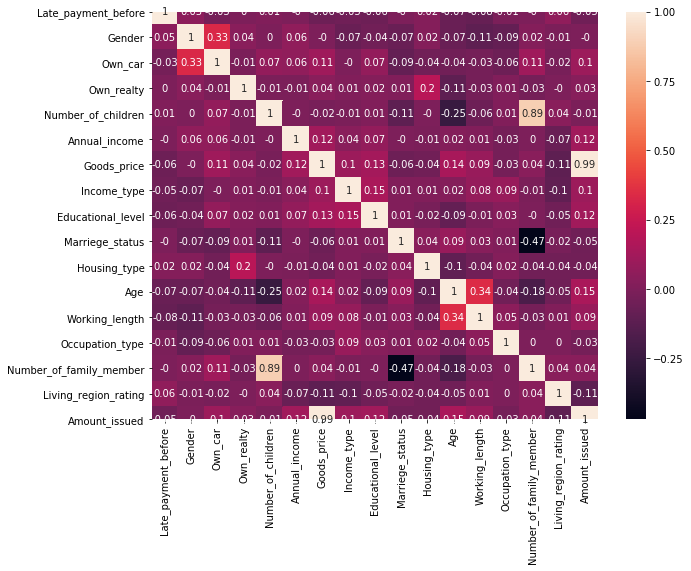

In [12]:
correlation_matrix = cash_loan_df.corr().round(2)

plt.subplots(figsize=(10, 7.5))
sns.heatmap(data = correlation_matrix, annot = True)

In [13]:
# calculate the correlation coefficient
cash_loan_df.corr().round(2).iloc[:, -1]

Late_payment_before       -0.05
Gender                    -0.00
Own_car                    0.10
Own_realty                 0.03
Number_of_children        -0.01
Annual_income              0.12
Goods_price                0.99
Income_type                0.10
Educational_level          0.12
Marriege_status           -0.05
Housing_type              -0.04
Age                        0.15
Working_length             0.09
Occupation_type           -0.03
Number_of_family_member    0.04
Living_region_rating      -0.11
Amount_issued              1.00
Name: Amount_issued, dtype: float64

In [14]:
# prepare the data
x_train, y_train, x_test, y_test = data_preparation(cash_loan_df)

## 2.1 Linear Regression

In [15]:
# train by linear regression
mlr = LinearRegression()
mlr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [16]:
print("Performance on Training set:")
get_metrics(x_train, y_train, mlr)
print("\nPerformance on Testing set:")
get_metrics(x_test, y_test, mlr)

Performance on Training set:
RMSE: 66826.51279853896 
R2 score: 0.9730967778782776

Performance on Testing set:
RMSE: 66875.12229400582 
R2 score: 0.9734176681610894


## 2.2 Polynomial Regression

In [17]:
dic = {}
l_r2 = []
for i in range(1, 4):
    
    poly = PolynomialFeatures(degree = i)
    poly_x_train = poly.fit_transform(x_train)
    poly_reg = LinearRegression()
    poly_reg.fit(poly_x_train, y_train)
    
    rmse = np.sqrt(mean_squared_error(y_train, poly_reg.predict(poly_x_train)))
    r2 = r2_score(y_train, poly_reg.predict(poly_x_train))
    
    dic[i] = [i, rmse, r2]

poly_train_result = pd.DataFrame.from_dict(dic, orient = 'index', columns = ["Degree", "RMSE", "R2"])  
display(poly_train_result.set_index("Degree"))

,RMSE,R2
Degree,,
1,66826.512799,0.973097
2,65525.857762,0.974134
3,64908.217742,0.974619


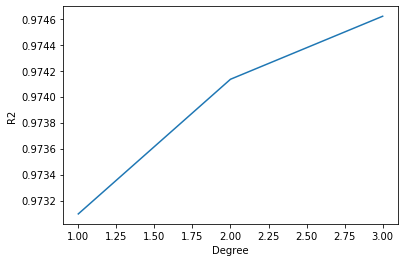

In [18]:
sns.lineplot(data = poly_train_result, x = "Degree", y = "R2", markers = True)

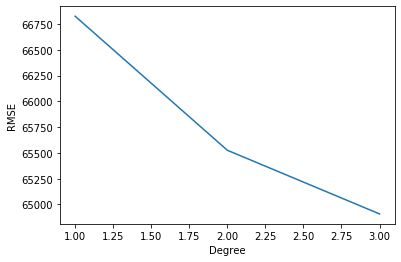

In [19]:
sns.lineplot(data = poly_train_result, x = "Degree", y = "RMSE", markers = True)

In [20]:
# from the figure above, the best degree is 3
poly = PolynomialFeatures(degree = 3)
poly_x_train = poly.fit_transform(x_train)
poly_x_test = poly.fit_transform(x_test)
poly_reg = LinearRegression()
poly_reg.fit(poly_x_train, y_train)
    
print("Performance on Training set:")
get_metrics(poly_x_train, y_train, poly_reg)
print("\nPerformance on Testing set:")
get_metrics(poly_x_test, y_test, poly_reg)

Performance on Training set:
RMSE: 64908.21774179111 
R2 score: 0.974619155510872

Performance on Testing set:
RMSE: 65428.387948987925 
R2 score: 0.9745553584610671


## 2.3 Ridge

In [21]:
dic = {}
for n in [0.001, 0.01, 0.1, 10, 30, 50, 60, 70, 80, 90, 100]:
    
    # train ridge model
    ridge = Ridge(alpha = n)
    ridge.fit(x_train, y_train)
    
    # rmse, r2 for train
    ridge_train_predict = ridge.predict(x_train)
    ridge_train_mse = mean_squared_error(y_train, ridge_train_predict)
    ridge_train_rmse = (np.sqrt(ridge_train_mse))
    ridge_train_r2 = r2_score(y_train, ridge_train_predict)
    
    dic[n] = [n, ridge_train_rmse, ridge_train_r2]
    
ridge_train_result = pd.DataFrame.from_dict(dic, orient = 'index', 
                                            columns = ["Lambda", "RMSE", "R_2"])
display(ridge_train_result.set_index("Lambda"))

,RMSE,R_2
Lambda,,
0.001,66826.512799,0.973097
0.010,66826.512799,0.973097
0.100,66826.512799,0.973097
10.000,66826.519775,0.973097
30.000,66826.575533,0.973097
50.000,66826.686918,0.973097
60.000,66826.763427,0.973097
70.000,66826.853791,0.973097
80.000,66826.957995,0.973096


In [22]:
# from the table above, when alpha = 0.01, the ridge performs best

# train ridge model
ridge = Ridge(alpha = 0.01)
ridge.fit(x_train, y_train)

print("Performance on Training set:")
get_metrics(x_train, y_train, ridge)
print("\nPerformance on Testing set:")
get_metrics(x_test, y_test, ridge)

Performance on Training set:
RMSE: 66826.51279854594 
R2 score: 0.9730967778782721

Performance on Testing set:
RMSE: 66875.12237699202 
R2 score: 0.9734176680951167


## 2.4 Lasso

In [23]:
dic = {}
for n in [0.001, 0.01, 0.1, 10, 30, 50, 60, 70, 80, 90, 100]:
    
    # train lasso model
    lasso = Lasso(alpha = n)
    lasso.fit(x_train, y_train)
    
    # rmse, r2 for train
    lasso_train_predict = lasso.predict(x_train)
    lasso_train_mse = mean_squared_error(y_train, lasso_train_predict)
    lasso_train_rmse = (np.sqrt(lasso_train_mse))
    lasso_train_r2 = r2_score(y_train, lasso_train_predict)
    
    dic[n] = [n, lasso_train_rmse, lasso_train_r2]
    
lasso_train_result = pd.DataFrame.from_dict(dic, orient = 'index', 
                                            columns = ["Lambda", "RMSE", "R_2"])
display(lasso_train_result.set_index("Lambda"))

,RMSE,R_2
Lambda,,
0.001,66826.512799,0.973097
0.010,66826.512799,0.973097
0.100,66826.512808,0.973097
10.000,66826.602368,0.973097
30.000,66827.318381,0.973096
50.000,66828.742452,0.973095
60.000,66829.730836,0.973094
70.000,66830.873896,0.973093
80.000,66832.224200,0.973092


In [24]:
# from the table above, when alpha = 0.01, the lasso performs best

# train ridge model
lasso = Lasso(alpha = 0.01)
lasso.fit(x_train, y_train)

print("Performance on Training set:")
get_metrics(x_train, y_train, lasso)
print("\nPerformance on Testing set:")
get_metrics(x_test, y_test, lasso)

Performance on Training set:
RMSE: 66826.51279862865 
R2 score: 0.9730967778782055

Performance on Testing set:
RMSE: 66875.12251101842 
R2 score: 0.9734176679885678


## 2.5 Regression Tree

In [25]:
def cross_validation_on_regression_tree(x, y, depths, cv):
    cv_scores_list = []

    for i in depths:
        tree_model = DecisionTreeRegressor(max_depth = i)
        cv_score = cross_val_score(tree_model, x, y, cv=cv, scoring = "r2").mean()
        cv_scores_list.append(cv_score)
    return cv_scores_list

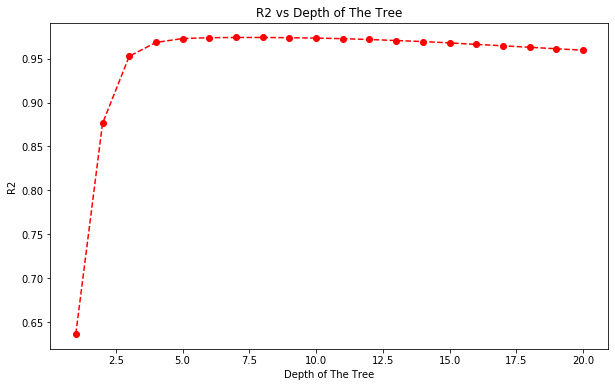

In [26]:
plt.figure(figsize = (10, 6))
cv_score_list = cross_validation_on_regression_tree(x_train, y_train, range(1, 21), 10)

plt.plot(range(1, 21), cv_score_list, color = "red", marker = 'o', linestyle = '--')  
plt.xlabel('Depth of The Tree')
plt.ylabel('R2')
plt.title('R2 vs Depth of The Tree')
plt.show()

In [27]:
# from the figure, the regression tree performs best at depth 6
reg_tree = DecisionTreeRegressor(max_depth = 6)
reg_tree.fit(x_train, y_train)

print("Performance on Training set:")
get_metrics(x_train, y_train, reg_tree)
print("\nPerformance on Testing set:")
get_metrics(x_test, y_test, reg_tree)

Performance on Training set:
RMSE: 65696.55936906359 
R2 score: 0.9739988863040431

Performance on Testing set:
RMSE: 65924.74983282771 
R2 score: 0.9741678307415553


# 3. Revolving Loan

In [28]:
revolving_loan_df.head(10)

,Late_payment_before,Gender,Own_car,Own_realty,Number_of_children,Annual_income,Goods_price,Income_type,Educational_level,Marriege_status,Housing_type,Age,Working_length,Occupation_type,Number_of_family_member,Living_region_rating,Amount_issued
298121,0,0,0,0,1,63765.0,135000.0,0,0,1,0,32.90,4.60,3,3.0,2,135000.0
71193,0,1,1,1,1,225000.0,180000.0,0,0,2,0,28.21,9.94,4,2.0,2,180000.0
269692,0,0,0,0,1,94500.0,180000.0,0,1,1,0,22.06,1.50,3,3.0,2,180000.0
270364,0,1,0,1,0,225000.0,180000.0,1,0,1,5,46.60,4.60,2,2.0,2,180000.0
144142,0,0,0,0,0,382500.0,1125000.0,1,2,2,0,41.03,4.62,0,1.0,1,1125000.0
109860,0,0,0,0,1,63000.0,157500.0,0,0,1,0,34.42,3.40,9,3.0,2,157500.0
4764,0,0,0,0,0,67500.0,247500.0,1,0,2,0,21.37,1.55,9,1.0,2,247500.0
27230,0,1,1,0,1,184500.0,180000.0,0,0,2,0,32.37,4.27,9,2.0,2,180000.0
63816,0,1,1,0,0,202500.0,270000.0,0,0,2,0,30.88,3.20,9,1.0,2,270000.0
60834,0,0,0,0,0,225000.0,675000.0,0,0,1,0,50.46,13.80,14,2.0,3,675000.0


In [29]:
# define scaler, use standard scaler
scaler = StandardScaler()

features = list(revolving_loan_df.columns)[:-1]
# use stardard scaler to scale data, used for gradient descent
revolving_loan_df[features] = scaler.fit_transform(revolving_loan_df[list(features)])

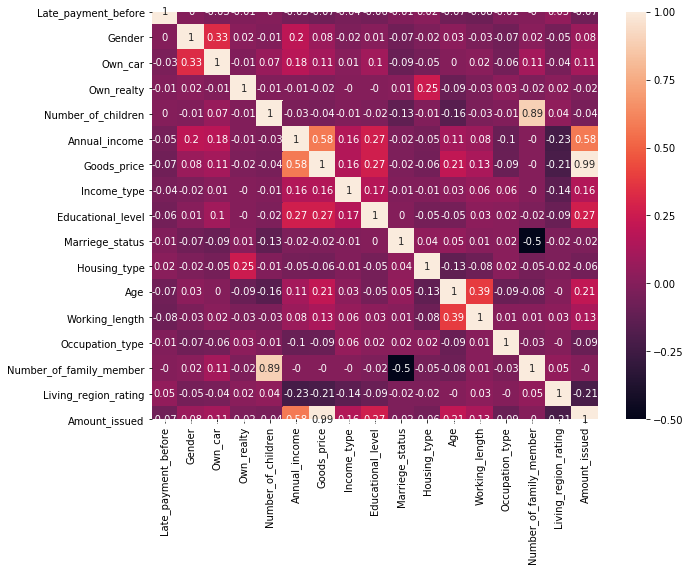

In [30]:
correlation_matrix = revolving_loan_df.corr().round(2)

plt.subplots(figsize=(10, 7.5))
sns.heatmap(data = correlation_matrix, annot = True)

In [31]:
# calculate the correlation coefficient
revolving_loan_df.corr().round(2).iloc[:, -1]

Late_payment_before       -0.07
Gender                     0.08
Own_car                    0.11
Own_realty                -0.02
Number_of_children        -0.04
Annual_income              0.58
Goods_price                0.99
Income_type                0.16
Educational_level          0.27
Marriege_status           -0.02
Housing_type              -0.06
Age                        0.21
Working_length             0.13
Occupation_type           -0.09
Number_of_family_member   -0.00
Living_region_rating      -0.21
Amount_issued              1.00
Name: Amount_issued, dtype: float64

In [32]:
# prepare the data
x_train, y_train, x_test, y_test = data_preparation(revolving_loan_df)

## 3.1 Linear Regression

In [33]:
# train by linear regression
mlr = LinearRegression()
mlr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [34]:
print("Performance on Training set:")
get_metrics(x_train, y_train, mlr)
print("\nPerformance on Testing set:")
get_metrics(x_test, y_test, mlr)

Performance on Training set:
RMSE: 25218.97938955007 
R2 score: 0.9883967160226504

Performance on Testing set:
RMSE: 21999.94879771412 
R2 score: 0.9909757030913187


## 3.2 Polynomial Regression

In [35]:
dic = {}
l_r2 = []
for i in range(1, 4):
    
    poly = PolynomialFeatures(degree = i)
    poly_x_train = poly.fit_transform(x_train)
    poly_reg = LinearRegression()
    poly_reg.fit(poly_x_train, y_train)
    
    rmse = np.sqrt(mean_squared_error(y_train, poly_reg.predict(poly_x_train)))
    r2 = r2_score(y_train, poly_reg.predict(poly_x_train))
    
    dic[i] = [i, rmse, r2]

poly_train_result = pd.DataFrame.from_dict(dic, orient = 'index', columns = ["Degree", "RMSE", "R2"])  
display(poly_train_result.set_index("Degree"))

,RMSE,R2
Degree,,
1,25218.979390,0.988397
2,24947.388445,0.988645
3,23427.628030,0.989987


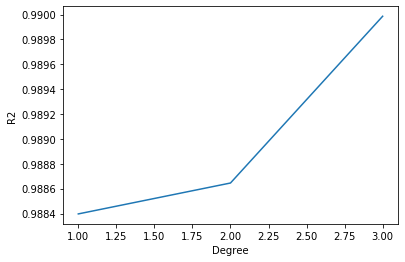

In [36]:
sns.lineplot(data = poly_train_result, x = "Degree", y = "R2", markers = True)

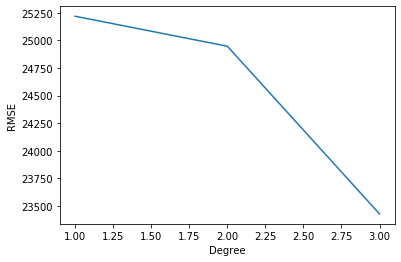

In [37]:
sns.lineplot(data = poly_train_result, x = "Degree", y = "RMSE", markers = True)

In [38]:
# from the figure above, the best degree is 3
poly = PolynomialFeatures(degree = 3)
poly_x_train = poly.fit_transform(x_train)
poly_x_test = poly.fit_transform(x_test)
poly_reg = LinearRegression()
poly_reg.fit(poly_x_train, y_train)
    
print("Performance on Training set:")
get_metrics(poly_x_train, y_train, poly_reg)
print("\nPerformance on Testing set:")
get_metrics(poly_x_test, y_test, poly_reg)

Performance on Training set:
RMSE: 23427.62802994458 
R2 score: 0.9899865773437321

Performance on Testing set:
RMSE: 314939369544.7171 
R2 score: -1849370573606.1538


## 3.3 Ridge

In [39]:
dic = {}
for n in [0.001, 0.01, 0.1, 10, 30, 50, 60, 70, 80, 90, 100]:
    
    # train ridge model
    ridge = Ridge(alpha = n)
    ridge.fit(x_train, y_train)
    
    # rmse, r2 for train
    ridge_train_predict = ridge.predict(x_train)
    ridge_train_mse = mean_squared_error(y_train, ridge_train_predict)
    ridge_train_rmse = (np.sqrt(ridge_train_mse))
    ridge_train_r2 = r2_score(y_train, ridge_train_predict)
    
    dic[n] = [n, ridge_train_rmse, ridge_train_r2]
    
ridge_train_result = pd.DataFrame.from_dict(dic, orient = 'index', 
                                            columns = ["Lambda", "RMSE", "R_2"])
display(ridge_train_result.set_index("Lambda"))

,RMSE,R_2
Lambda,,
0.001,25218.979390,0.988397
0.010,25218.979390,0.988397
0.100,25218.979456,0.988397
10.000,25219.641189,0.988396
30.000,25224.903086,0.988391
50.000,25235.342959,0.988382
60.000,25242.476861,0.988375
70.000,25250.871742,0.988367
80.000,25260.516250,0.988358


In [40]:
# from the table above, when alpha = 0.01, the ridge performs best

# train ridge model
ridge = Ridge(alpha = 0.01)
ridge.fit(x_train, y_train)

print("Performance on Training set:")
get_metrics(x_train, y_train, ridge)
print("\nPerformance on Testing set:")
get_metrics(x_test, y_test, ridge)

Performance on Training set:
RMSE: 25218.97939021366 
R2 score: 0.9883967160220398

Performance on Testing set:
RMSE: 21999.95541357441 
R2 score: 0.9909756976637154


## 3.4 Lasso

In [41]:
dic = {}
for n in [0.001, 0.01, 0.1, 10, 30, 50, 60, 70, 80, 90, 100]:
    
    # train lasso model
    lasso = Lasso(alpha = n)
    lasso.fit(x_train, y_train)
    
    # rmse, r2 for train
    lasso_train_predict = lasso.predict(x_train)
    lasso_train_mse = mean_squared_error(y_train, lasso_train_predict)
    lasso_train_rmse = (np.sqrt(lasso_train_mse))
    lasso_train_r2 = r2_score(y_train, lasso_train_predict)
    
    dic[n] = [n, lasso_train_rmse, lasso_train_r2]
    
lasso_train_result = pd.DataFrame.from_dict(dic, orient = 'index', 
                                            columns = ["Lambda", "RMSE", "R_2"])
display(lasso_train_result.set_index("Lambda"))

,RMSE,R_2
Lambda,,
0.001,25218.979390,0.988397
0.010,25218.979390,0.988397
0.100,25218.979393,0.988397
10.000,25219.009935,0.988397
30.000,25219.958224,0.988396
50.000,25221.247815,0.988395
60.000,25221.484570,0.988394
70.000,25221.752497,0.988394
80.000,25222.068490,0.988394


In [42]:
# from the table above, when alpha = 0.01, the lasso performs best

# train ridge model
lasso = Lasso(alpha = 0.01)
lasso.fit(x_train, y_train)

print("Performance on Training set:")
get_metrics(x_train, y_train, lasso)
print("\nPerformance on Testing set:")
get_metrics(x_test, y_test, lasso)

Performance on Training set:
RMSE: 25218.979389579847 
R2 score: 0.988396716022623

Performance on Testing set:
RMSE: 21999.948736285274 
R2 score: 0.9909757031417145


## 3.5 Decision Tree Regression

In [43]:
def cross_validation_on_regression_tree(x, y, depths, cv):
    cv_scores_list = []

    for i in depths:
        tree_model = DecisionTreeRegressor(max_depth = i)
        cv_score = cross_val_score(tree_model, x, y, cv=cv, scoring = "r2").mean()
        cv_scores_list.append(cv_score)
    return cv_scores_list

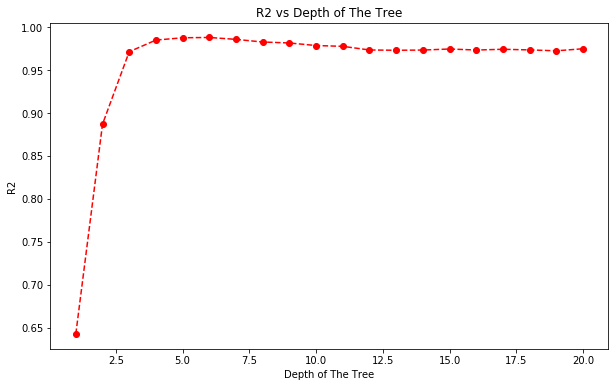

In [45]:
plt.figure(figsize = (10, 6))
cv_score_list = cross_validation_on_regression_tree(x_train, y_train, range(1, 21), 10)

plt.plot(range(1, 21), cv_score_list, color = "red", marker = 'o', linestyle = '--')  
plt.xlabel('Depth of The Tree')
plt.ylabel('R2')
plt.title('R2 vs Depth of The Tree')
plt.show()

In [46]:
# from the figure, the regression tree performs best at depth 6
reg_tree = DecisionTreeRegressor(max_depth = 6)
reg_tree.fit(x_train, y_train)

print("Performance on Training set:")
get_metrics(x_train, y_train, reg_tree)
print("\nPerformance on Testing set:")
get_metrics(x_test, y_test, reg_tree)

Performance on Training set:
RMSE: 22931.78816632904 
R2 score: 0.990405955016634

Performance on Testing set:
RMSE: 24217.741392761054 
R2 score: 0.9890645336103514
